In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import os
from sklearn.manifold import TSNE
import scipy
import imageio
import cv2

from vae import VAE

C:\Users\ldoci\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the model

In [3]:
from models import vae_mnist
model = VAE(**vae_mnist)
model.eval()
model.load_state_dict(torch.load("model_020000.pickle"))

<All keys matched successfully>

# Load dataset

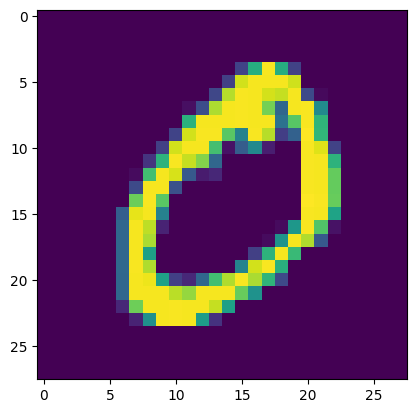

In [4]:
mnist = torchvision.datasets.MNIST(".", download=True)

img, label = mnist[1]
img_np = np.float32(img)[None]/255.0
img_t = torch.from_numpy(img_np)
label_t = torch.LongTensor([label])

plt.figure()
plt.imshow(img)

# Try encode + decode

torch.Size([1, 6272]) torch.Size([1, 6272])
tensor([[ 0.6155, -1.1334,  1.3214,  ..., -0.6802,  1.0325,  0.2156]],
       grad_fn=<AddBackward0>)


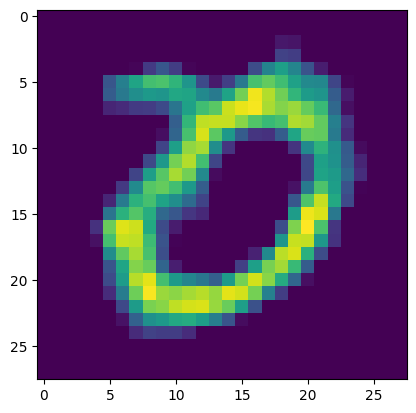

In [5]:
mean, log_variance = model.encoder(img_t[None])
std = torch.exp(0.5*log_variance)
print(mean.shape, log_variance.shape)

z = mean + std*torch.randn_like(std)
print(z)
x_hat = model.decoder(z)

plt.figure()
plt.imshow(x_hat.data.numpy()[0,0])

# Obtain the latent for a few samples

In [6]:
zs = []
labels = []
for i in range(2000):
    img, label = mnist[i]
    img_np = np.float32(img)[None]/255.0
    img_t = torch.from_numpy(img_np)
    label_t = torch.LongTensor([label])

    mean, log_variance = model.encoder(img_t[None])
    std = torch.exp(0.5*log_variance)

    zs.append(mean.data.numpy().ravel())
    labels.append(label)
zs = np.array(zs)
labels = np.array(labels)

# Compute and display a TSNE embedding

(-70.63836193084717,
 59.27352046966553,
 -51.781243896484376,
 53.638421630859376)

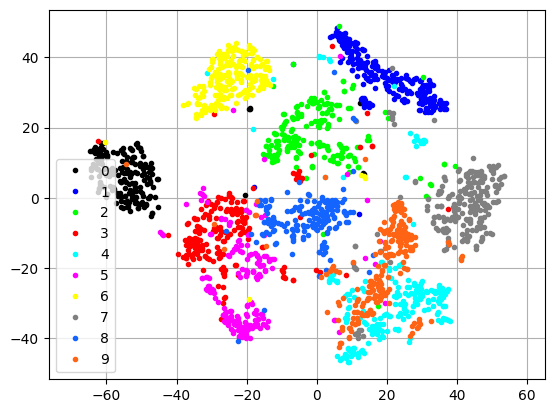

In [7]:
embed = TSNE().fit_transform(zs)

colors = {
    0:[0,0,0],
    1:[0,0,255],
    2:[0,255,0],
    3:[255,0,0],
    4:[0,255,255],
    5:[255,0,255],
    6:[255,255,0],
    7:[128,128,128],
    8:[20,100,255],
    9:[255,100,20]
}

plt.figure()
for i in range(10):
    m = labels==i
    plt.plot(embed[m,0], embed[m,1], '.', color=np.array(colors[i])/255, label=f'{i}')
plt.legend()
plt.grid()
plt.axis('equal')

In [8]:
from scipy import interpolate

def interpolate_(vector1, t1, vector2, t2):
    
    t_new = np.arange(t1+1, t2)
    f = interpolate.interp1d(np.array([t1,t2]), np.array([vector1,vector2]).T)
    vector_new = f(t_new).T
    
    return vector_new

def smooth_trajectory(trajectory, indexes, s=None, k=2):
    
    # remove None if presents
    _indexes, _x = list(zip(*[(i,x) for i,x in zip(indexes, trajectory) if x is not None]))
    
    # reshape to what splprep expetcs
    _x = np.array(_x)
    shape = _x.shape
    _x = _x.reshape(_x.shape[0], -1)
    
    # removing duplicates
    _,idxs = np.unique(_x, return_index=True, axis=0)  
    _indexes = np.array(_indexes)[idxs]
    _x = _x[idxs]
    idxs2 = np.argsort(_indexes)
    _indexes = _indexes[idxs2]
    _x = _x[idxs2]    
    
    # interpolate + smoothing
    tck, _ = interpolate.splprep(_x.T, s=s, k=k, u=_indexes)
    _x_new = np.array(interpolate.splev(indexes, tck)).T
    _x_new = _x_new.reshape(*shape)
    
    return _x_new.tolist()

# Compute cluster centers

In [9]:
cluster_centers = []
for i in range(10):
    m = labels==i
    cluster_centers.append(np.median(zs[m], axis=0))
cluster_centers = np.array(cluster_centers)
cluster_centers.shape

(10, 6272)

# Make a trajectory and oversample it to increase granularity 

In [10]:
N = 200
interpolated = []
for c1,c2 in zip(cluster_centers[:-1], cluster_centers[1:]):
    interpolated += [c1]
    interpolated += interpolate_(c1, 0, c2, N).tolist()
interpolated += [cluster_centers[-1]]
interpolated = np.array(interpolated)
interpolated.shape

(1801, 6272)

# Save reconstructions

In [52]:
for i, x in enumerate(interpolated):
    z = torch.from_numpy(np.float32(x))[None] #+ std*torch.randn_like(std)
    x_hat = model.decoder(z)
    x_hat = x_hat.data.numpy()[0,0]
    x_hat -= x_hat.min()
    x_hat /= x_hat.max()
    x_hat = np.uint8(x_hat*255)
    x_hat = cv2.resize(x_hat, (256,256), cv2.INTER_AREA)
    
    imageio.imwrite(f"media/frame_{i:04d}.jpg", x_hat)

# Plot trajectory into TSNE embedding space

(-67.41970081329346, 68.92694492340088, -63.96809844970703, 72.15297393798828)

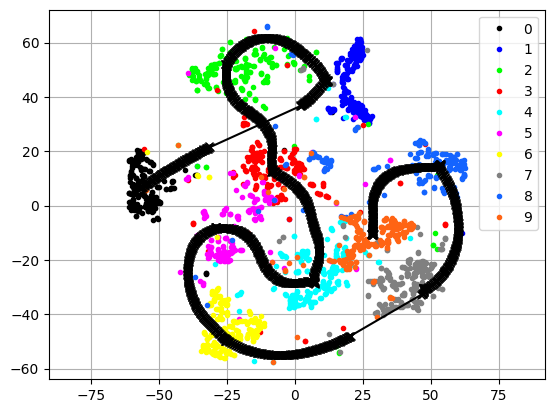

In [11]:
zsp = np.vstack([zs, interpolated])
labelsp = np.concatenate([labels, np.zeros(len(interpolated))-1])
embed = TSNE().fit_transform(zsp)

plt.figure()
for i in range(10):
    m = labelsp==i
    plt.plot(embed[m,0], embed[m,1], '.', color=np.array(colors[i])/255, label=f'{i}')
m = labelsp==-1
plt.plot(embed[m,0], embed[m,1], 'x-', color=[0,0,0])    
plt.legend()
plt.grid()
plt.axis('equal')

# Save the final images

In [56]:
m = labelsp==-1
for i,_ in enumerate(interpolated):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for j in range(10):
        m = labelsp==j
        plt.plot(embed[m,0], embed[m,1], '.', color=np.array(colors[j])/255, label=f'{j}')
    m = labelsp==-1
    plt.plot(embed[m,0], embed[m,1], '.-', color=[0,0,0]) 
    plt.plot(embed[m,0][[i]], embed[m,1][[i]], 'o', color=[1,0,0], markersize=10) 
    plt.legend()
    plt.grid()
    plt.axis('equal')    
    plt.subplot(1,2,2)
    plt.imshow(imageio.imread(f"media/frame_{i:04d}.jpg"), cmap='grey')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"media/plot_{i:04d}.jpg", dpi=100)
    plt.close()

C:\Users\ldoci\AppData\Local\Temp\ipykernel_15036\3509997796.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(f"media/frame_{i:04d}.jpg"), cmap='grey')
C:\Users\ldoci\AppData\Local\Temp\ipykernel_15036\3509997796.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(f"media/frame_{i:04d}.jpg"), cmap='grey')
C:\Users\ldoci\AppData\Local\Temp\ipykernel_15036\3509997796.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this w